In [ ]:
!pip install 'portalocker>=2.0.0'

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torchtext.datasets import IMDB

train_dataset = IMDB(split='train')
test_dataset = IMDB(split='test')


In [ ]:
#create dataset
from torch.utils.data.dataset import random_split
from sklearn.model_selection import train_test_split
torch.manual_seed(1)
train_dataset,valid_dataset = random_split(list(train_dataset),[20000,5000])


In [ ]:
import re
from collections import Counter, OrderedDict
def tokenizer(text):
  text = re.sub('<[^>]*>', '', text)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
  text = re.sub('[\W]+', ' ', text.lower()) +\
      ' '.join(emoticons).replace('-', '')
  tokenized = text.split()
  return tokenized

token_counts = Counter()

for label,line in train_dataset:
  tokens = tokenizer(line)
  token_counts.update(tokens)

print('Vocab-size: ',len(token_counts))

Vocab-size:  69023


In [ ]:
token_counts


Counter({'an': 17204,
         'extra': 244,
         'is': 85847,
         'called': 1140,
         'upon': 675,
         'to': 107513,
         'play': 1752,
         'a': 130057,
         'general': 619,
         'in': 74646,
         'movie': 35149,
         'about': 13734,
         'the': 267877,
         'russian': 250,
         'revolution': 160,
         'however': 2892,
         'he': 24075,
         'not': 24329,
         'any': 6089,
         'ordinary': 222,
         'serguis': 2,
         'alexander': 100,
         'former': 416,
         'commanding': 37,
         'of': 116119,
         'russia': 66,
         'armies': 17,
         'who': 17112,
         'now': 3704,
         'being': 5224,
         'forced': 505,
         'relive': 19,
         'same': 3244,
         'scene': 4223,
         'which': 9563,
         'suffered': 116,
         'professional': 270,
         'and': 130797,
         'personal': 510,
         'tragedy': 291,
         'satisfy': 73,
         'dir

In [ ]:
from torchtext.vocab import vocab

sorted_by_freq_tuples = sorted(
    token_counts.items(), key=lambda x:x[1], reverse=True
)
ordered_dict = OrderedDict(sorted_by_freq_tuples)
vocab = vocab(ordered_dict)
vocab.insert_token("<pad>",0)
vocab.insert_token("<unk>",1)
vocab.set_default_index(1)
print([vocab[token] for token in ['this','is','an','example']])

[11, 7, 35, 457]


In [ ]:
text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]
label_pipeline = lambda x: 1. if x==2 else 0.

def collate_batch(batch):
  label_list, text_list, lengths = [], [], []
  for _label,_text in batch:
    label_list.append(label_pipeline(_label))
    processed_text = torch.tensor(text_pipeline(_text),dtype=torch.int64)
    text_list.append(processed_text)
    lengths.append(processed_text.size(0))
  label_list = torch.tensor(label_list)
  lengths = torch.tensor(lengths)
  padded_text_list = torch.nn.utils.rnn.pad_sequence(text_list,batch_first=True)
  return padded_text_list,label_list,lengths

from torch.utils.data import DataLoader
dataloader = DataLoader(train_dataset,batch_size=4,shuffle=False,collate_fn=collate_batch)

In [ ]:
# text_batch, label_batch, length_batch = next(iter(dataloader))
# print(text_batch)
# print(label_batch)
# print(length_batch)
# print(text_batch.shape)

batch_size = 50
train_dl = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,collate_fn=collate_batch)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size,shuffle=False,collate_fn=collate_batch)
test_dl = DataLoader(test_dataset, batch_size=batch_size,shuffle=False,collate_fn=collate_batch)


In [ ]:
embedding = torch.nn.Embedding(num_embeddings=10, embedding_dim=3,padding_idx=0)
text_encoded_input = torch.LongTensor([[1,2,4,5],[4,3,2,0]])
print(embedding(text_encoded_input))

tensor([[[ 0.1187, -0.5282,  0.7039],
         [-0.8321, -0.4651,  0.3234],
         [-0.3531,  0.9124,  0.3710],
         [-0.3757,  0.7046, -0.7106]],

        [[-0.3531,  0.9124,  0.3710],
         [-0.1976,  0.5566,  0.0946],
         [-0.8321, -0.4651,  0.3234],
         [ 0.0000,  0.0000,  0.0000]]], grad_fn=<EmbeddingBackward0>)


In [ ]:
class RNN_test(torch.nn.Module):
  def __init__(self,input_size,hidden_size):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size,hidden_size,num_layers=2,batch_first=True)
    #self.rnn = torch.nn.GRU(input_size,hidden_size,num_layers=2,batch_first=True)
    #self.rnn = torch.nn.LSTM(input_size,hidden_size,num_layers=2,batch_first=True)

    self.fc = torch.nn.Linear(hidden_size,1)

  def forward(self,x):
    _,hidden = self.rnn(x)
    out = hidden[-1,:,:]
    out = self.fc(out)
    return out

model = RNN_test(64,32)
print(model)
model(torch.randn(5,3,64))

RNN_test(
  (rnn): RNN(64, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


tensor([[-0.1777],
        [-0.2205],
        [-0.2145],
        [-0.0255],
        [-0.3875]], grad_fn=<AddmmBackward0>)

In [ ]:
class RNN_LSTM(torch.nn.Module):
  def __init__(self,vocab_size,embed_dim,rnn_hidden_size,fc_hidden_size):
    super().__init__()
    self.embedding = torch.nn.Embedding(vocab_size,embed_dim,padding_idx=0)
    self.rnn = torch.nn.LSTM(embed_dim,rnn_hidden_size,batch_first=True)
    self.fc1 = torch.nn.Linear(rnn_hidden_size,fc_hidden_size)
    self.relu = torch.nn.ReLU()
    self.fc2 = torch.nn.Linear(fc_hidden_size,1)
    self.sigmoid = torch.nn.Sigmoid()

  def forward(self,text,lengths):
    out = self.embedding(text)
    out = torch.nn.utils.rnn.pack_padded_sequence(out,lengths.cpu().numpy(),enforce_sorted=False,batch_first=True)
    out,(hidden,cell) = self.rnn(out)
    out = hidden[-1,:,:]
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.sigmoid(out)
    return out


RNN_LSTM(
  (embedding): Embedding(69025, 20, padding_idx=0)
  (rnn): LSTM(20, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
class RNN(torch.nn.Module):
  def __init__(self,vocab_size,embed_dim,rnn_hidden_size,fc_hidden_size):
    super().__init__()
    self.embedding = torch.nn.Embedding(vocab_size,embed_dim,padding_idx=0)
    self.rnn = torch.nn.RNN(embed_dim,rnn_hidden_size,batch_first=True)
    self.fc1 = torch.nn.Linear(rnn_hidden_size,fc_hidden_size)
    self.relu = torch.nn.ReLU()
    self.fc2 = torch.nn.Linear(fc_hidden_size,1)
    self.sigmoid = torch.nn.Sigmoid()

  def forward(self,text,lengths):
    out = self.embedding(text)
    out = torch.nn.utils.rnn.pack_padded_sequence(out,lengths.cpu().numpy(),enforce_sorted=False,batch_first=True)
    _,hidden = self.rnn(out)
    out = hidden[-1,:,:]
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.sigmoid(out)
    return out

In [ ]:
class RNN_GRU(torch.nn.Module):
  def __init__(self,vocab_size,embed_dim,rnn_hidden_size,fc_hidden_size):
    super().__init__()
    self.embedding = torch.nn.Embedding(vocab_size,embed_dim,padding_idx=0)
    self.rnn = torch.nn.GRU(embed_dim,rnn_hidden_size,batch_first=True)
    self.fc1 = torch.nn.Linear(rnn_hidden_size,fc_hidden_size)
    self.relu = torch.nn.ReLU()
    self.fc2 = torch.nn.Linear(fc_hidden_size,1)
    self.sigmoid = torch.nn.Sigmoid()

  def forward(self,text,lengths):
    out = self.embedding(text)
    out = torch.nn.utils.rnn.pack_padded_sequence(out,lengths.cpu().numpy(),enforce_sorted=False,batch_first=True)
    _,hidden = self.rnn(out)
    out = hidden[-1,:,:]
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.sigmoid(out)
    return out

In [ ]:
vocab_size = len(vocab)
embed_dim = 20
rnn_hidden_size = 64
lstm_hidden_size = 32
gru_hidden_size = 32
fc_hidden_size = 64
torch.manual_seed(1)

model_RNN = RNN(vocab_size,embed_dim,rnn_hidden_size,fc_hidden_size)
model_LSTM = RNN_LSTM(vocab_size,embed_dim,lstm_hidden_size,fc_hidden_size)
model_GRU = RNN_GRU(vocab_size,embed_dim,gru_hidden_size,fc_hidden_size)

In [ ]:
len(valid_dl.dataset)

5000

In [ ]:
import time
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
def train(dataloader):
  model.train()
  total_acc,total_loss = 0,0
  for text_batch,label_batch,lengths in dataloader:
    optimizer.zero_grad()
    pred = model(text_batch,lengths)[:,0]
    loss = loss_fn(pred,label_batch)
    loss.backward()
    optimizer.step()
    total_acc += ((pred>=0.5).float()==label_batch).float().sum().item()
    total_loss += loss.item()*label_batch.size(0)
  return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

def evaluate(dataloader):
  model.eval()
  total_acc,total_loss = 0,0
  longitud=5000
  with torch.no_grad():
    for text_batch,label_batch,lengths in dataloader:
      pred = model(text_batch,lengths)[:,0]
      loss = loss_fn(pred,label_batch)
      total_acc += ((pred>=0.5).float()==label_batch).float().sum().item()
      total_loss += loss.item()*label_batch.size(0)
  return total_acc/longitud,total_loss/longitud

def evaluate_test(dataloader):
  model.eval()
  total_acc,total_loss = 0,0
  longitud=25000
  with torch.no_grad():
    for text_batch,label_batch,lengths in dataloader:
      pred = model(text_batch,lengths)[:,0]
      loss = loss_fn(pred,label_batch)
      total_acc += ((pred>=0.5).float()==label_batch).float().sum().item()
      total_loss += loss.item()*label_batch.size(0)
  return total_acc/longitud,total_loss/longitud

In [ ]:
import time
model = model_RNN
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
def train(dataloader):
  model.train()
  total_acc,total_loss = 0,0
  for text_batch,label_batch,lengths in dataloader:
    optimizer.zero_grad()
    pred = model(text_batch,lengths)[:,0]
    loss = loss_fn(pred,label_batch)
    loss.backward()
    optimizer.step()
    total_acc += ((pred>=0.5).float()==label_batch).float().sum().item()
    total_loss += loss.item()*label_batch.size(0)
  return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

def evaluate(dataloader):
  model.eval()
  total_acc,total_loss = 0,0
  longitud=5000
  with torch.no_grad():
    for text_batch,label_batch,lengths in dataloader:
      pred = model(text_batch,lengths)[:,0]
      loss = loss_fn(pred,label_batch)
      total_acc += ((pred>=0.5).float()==label_batch).float().sum().item()
      total_loss += loss.item()*label_batch.size(0)
  return total_acc/longitud,total_loss/longitud

def evaluate_test(dataloader):
  model.eval()
  total_acc,total_loss = 0,0
  longitud=25000
  with torch.no_grad():
    for text_batch,label_batch,lengths in dataloader:
      pred = model(text_batch,lengths)[:,0]
      loss = loss_fn(pred,label_batch)
      total_acc += ((pred>=0.5).float()==label_batch).float().sum().item()
      total_loss += loss.item()*label_batch.size(0)
  return total_acc/longitud,total_loss/longitud

num_epochs = 15
torch.manual_seed(1)
rnn_acc_train_vec=[]
rnn_loss_train_vec=[]
rnn_acc_valid_vec=[]
rnn_loss_valid_vec=[]
start_time=time.perf_counter()
for epoch in range(num_epochs):
  acc_train,loss_train = train(train_dl)
  rnn_acc_train_vec.append(acc_train)
  rnn_loss_train_vec.append(loss_train)
  acc_valid, loss_valid = evaluate(valid_dl)
  rnn_acc_valid_vec.append(acc_valid)
  rnn_loss_valid_vec.append(loss_valid)
  print(f'Epoch {epoch} accuracy: {acc_train:.4f} val_accuracy: {acc_valid:.4f} ')
end_time=time.perf_counter()


acc_test, _ = evaluate_test(test_dl)
print(f'test_accuracy: {acc_test:.4f}')
print('Tiempo de entrenamiento: ', end_time-start_time)


Epoch 0 accuracy: 0.5502 val_accuracy: 0.5682 
Epoch 1 accuracy: 0.6385 val_accuracy: 0.6544 
Epoch 2 accuracy: 0.6414 val_accuracy: 0.6092 
Epoch 3 accuracy: 0.6852 val_accuracy: 0.6736 
Epoch 4 accuracy: 0.7510 val_accuracy: 0.7086 
Epoch 5 accuracy: 0.7819 val_accuracy: 0.7230 
Epoch 6 accuracy: 0.8092 val_accuracy: 0.7456 
Epoch 7 accuracy: 0.6948 val_accuracy: 0.6468 
Epoch 8 accuracy: 0.7395 val_accuracy: 0.7024 
Epoch 9 accuracy: 0.8279 val_accuracy: 0.7622 
Epoch 10 accuracy: 0.8296 val_accuracy: 0.6758 
Epoch 11 accuracy: 0.8091 val_accuracy: 0.7428 
Epoch 12 accuracy: 0.8462 val_accuracy: 0.7530 
Epoch 13 accuracy: 0.8764 val_accuracy: 0.7574 
Epoch 14 accuracy: 0.8780 val_accuracy: 0.7642 
test_accuracy: 0.7657
Tiempo de entrenamiento:  2893.1333107500004


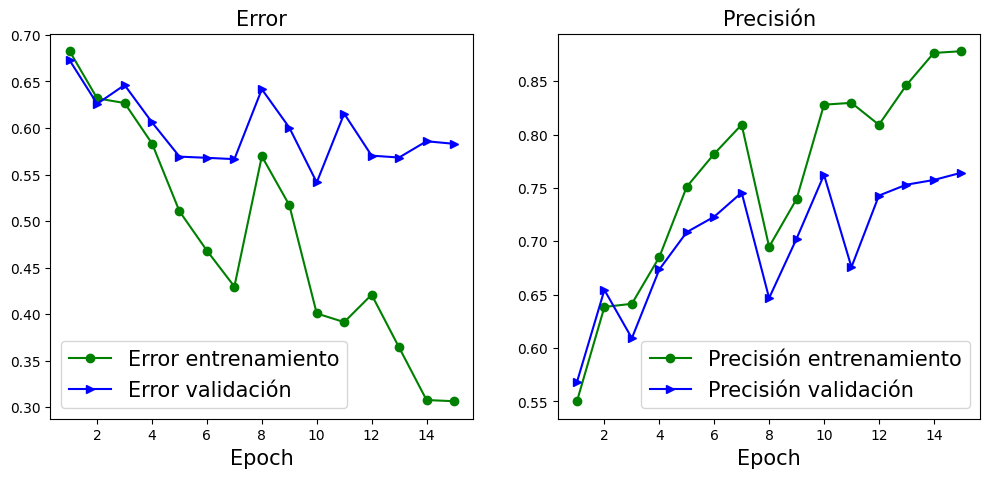

In [ ]:
import matplotlib.pyplot as plt
x_arr=np.arange(len(rnn_acc_train_vec))+1
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr,rnn_loss_train_vec,'-o',color='g',label='Error entrenamiento')
ax.plot(x_arr,rnn_loss_valid_vec,'->',color='b',label='Error validación')
ax.set_title('Error',size=15)
ax.set_xlabel('Epoch',size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1,2,2)
ax.plot(x_arr,rnn_acc_train_vec,'-o',color='g',label='Precisión entrenamiento')
ax.plot(x_arr,rnn_acc_valid_vec,'->',color='b',label='Precisión validación')
ax.set_title('Precisión',size=15)
ax.set_xlabel('Epoch',size=15)
ax.legend(fontsize=15)

In [ ]:
import time

model = model_LSTM



num_epochs = 10
torch.manual_seed(1)
lstm_acc_train_vec=[]
lstm_loss_train_vec=[]
lstm_acc_valid_vec=[]
lstm_loss_valid_vec=[]
start_time=time.perf_counter()
for epoch in range(num_epochs):
  acc_train,loss_train = train(train_dl)
  lstm_acc_train_vec.append(acc_train)
  lstm_loss_train_vec.append(loss_train)
  acc_valid, loss_valid = evaluate(valid_dl)
  lstm_acc_valid_vec.append(acc_valid)
  lstm_loss_valid_vec.append(loss_valid)
  print(f'Epoch {epoch} accuracy: {acc_train:.4f} val_accuracy: {acc_valid:.4f} ')
end_time=time.perf_counter()


acc_test, _ = evaluate_test(test_dl)
print(f'test_accuracy: {acc_test:.4f}')
print('Tiempo de entrenamiento: ', end_time-start_time)


Epoch 0 accuracy: 0.6069 val_accuracy: 0.6858 
Epoch 1 accuracy: 0.7425 val_accuracy: 0.7426 
Epoch 2 accuracy: 0.8041 val_accuracy: 0.6586 
Epoch 3 accuracy: 0.7885 val_accuracy: 0.7954 
Epoch 4 accuracy: 0.8636 val_accuracy: 0.8292 
Epoch 5 accuracy: 0.8902 val_accuracy: 0.8404 
Epoch 6 accuracy: 0.8998 val_accuracy: 0.8288 
Epoch 7 accuracy: 0.9270 val_accuracy: 0.8270 
Epoch 8 accuracy: 0.9373 val_accuracy: 0.8462 
Epoch 9 accuracy: 0.9351 val_accuracy: 0.8544 
test_accuracy: 0.8307
Tiempo de entrenamiento:  5843.345772860001


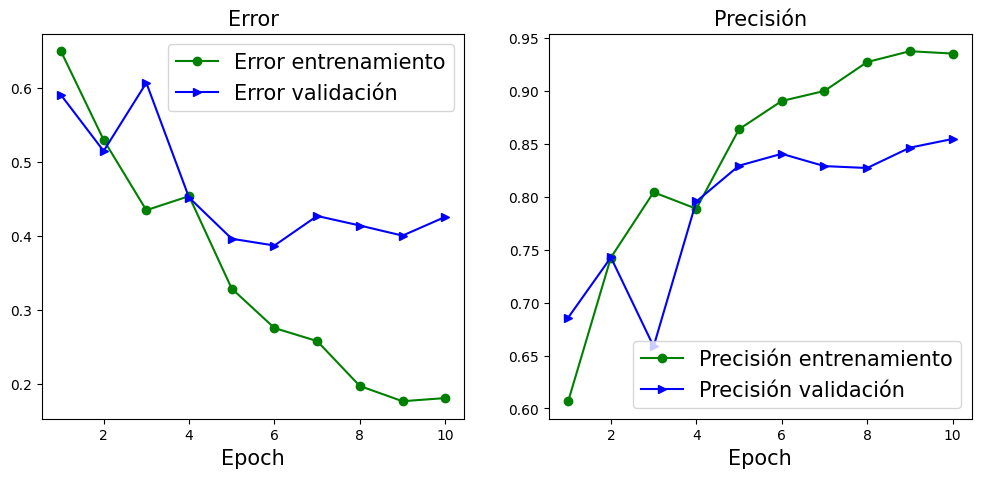

In [ ]:
import matplotlib.pyplot as plt
x_arr=np.arange(len(lstm_acc_train_vec))+1
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr,lstm_loss_train_vec,'-o',color='g',label='Error entrenamiento')
ax.plot(x_arr,lstm_loss_valid_vec,'->',color='b',label='Error validación')
ax.set_title('Error',size=15)
ax.set_xlabel('Epoch',size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1,2,2)
ax.plot(x_arr,lstm_acc_train_vec,'-o',color='g',label='Precisión entrenamiento')
ax.plot(x_arr,lstm_acc_valid_vec,'->',color='b',label='Precisión validación')
ax.set_title('Precisión',size=15)
ax.set_xlabel('Epoch',size=15)
ax.legend(fontsize=15)

In [ ]:
import time

model = model_GRU

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
def train(dataloader):
  model.train()
  total_acc,total_loss = 0,0
  for text_batch,label_batch,lengths in dataloader:
    optimizer.zero_grad()
    pred = model(text_batch,lengths)[:,0]
    loss = loss_fn(pred,label_batch)
    loss.backward()
    optimizer.step()
    total_acc += ((pred>=0.5).float()==label_batch).float().sum().item()
    total_loss += loss.item()*label_batch.size(0)
  return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

def evaluate(dataloader):
  model.eval()
  total_acc,total_loss = 0,0
  longitud=5000
  with torch.no_grad():
    for text_batch,label_batch,lengths in dataloader:
      pred = model(text_batch,lengths)[:,0]
      loss = loss_fn(pred,label_batch)
      total_acc += ((pred>=0.5).float()==label_batch).float().sum().item()
      total_loss += loss.item()*label_batch.size(0)
  return total_acc/longitud,total_loss/longitud

def evaluate_test(dataloader):
  model.eval()
  total_acc,total_loss = 0,0
  longitud=25000
  with torch.no_grad():
    for text_batch,label_batch,lengths in dataloader:
      pred = model(text_batch,lengths)[:,0]
      loss = loss_fn(pred,label_batch)
      total_acc += ((pred>=0.5).float()==label_batch).float().sum().item()
      total_loss += loss.item()*label_batch.size(0)
  return total_acc/longitud,total_loss/longitud

num_epochs = 10
torch.manual_seed(1)
gru_acc_train_vec=[]
gru_loss_train_vec=[]
gru_acc_valid_vec=[]
gru_loss_valid_vec=[]
start_time=time.perf_counter()
for epoch in range(num_epochs):
  acc_train,loss_train = train(train_dl)
  gru_acc_train_vec.append(acc_train)
  gru_loss_train_vec.append(loss_train)
  acc_valid, loss_valid = evaluate(valid_dl)
  gru_acc_valid_vec.append(acc_valid)
  gru_loss_valid_vec.append(loss_valid)
  print(f'Epoch {epoch} accuracy: {acc_train:.4f} val_accuracy: {acc_valid:.4f} ')
end_time=time.perf_counter()


acc_test, _ = evaluate_test(test_dl)
print(f'test_accuracy: {acc_test:.4f}')
print('Tiempo de entrenamiento: ', end_time-start_time)

Epoch 0 accuracy: 0.5858 val_accuracy: 0.6564 
Epoch 1 accuracy: 0.7353 val_accuracy: 0.7720 
Epoch 2 accuracy: 0.8267 val_accuracy: 0.8188 
Epoch 3 accuracy: 0.8746 val_accuracy: 0.8424 
Epoch 4 accuracy: 0.9035 val_accuracy: 0.8528 
Epoch 5 accuracy: 0.9237 val_accuracy: 0.8444 
Epoch 6 accuracy: 0.9393 val_accuracy: 0.8562 
Epoch 7 accuracy: 0.9501 val_accuracy: 0.8622 
Epoch 8 accuracy: 0.9646 val_accuracy: 0.8606 
Epoch 9 accuracy: 0.9717 val_accuracy: 0.8634 
test_accuracy: 0.8575
Tiempo de entrenamiento:  4692.805375315


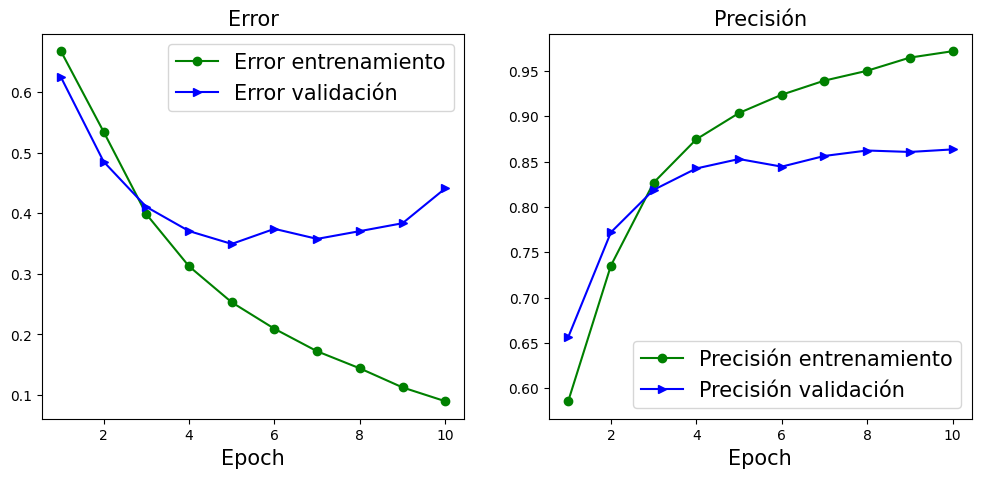

In [ ]:
import matplotlib.pyplot as plt
x_arr=np.arange(len(gru_acc_train_vec))+1
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr,gru_loss_train_vec,'-o',color='g',label='Error entrenamiento')
ax.plot(x_arr,gru_loss_valid_vec,'->',color='b',label='Error validación')
ax.set_title('Error',size=15)
ax.set_xlabel('Epoch',size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1,2,2)
ax.plot(x_arr,gru_acc_train_vec,'-o',color='g',label='Precisión entrenamiento')
ax.plot(x_arr,gru_acc_valid_vec,'->',color='b',label='Precisión validación')
ax.set_title('Precisión',size=15)
ax.set_xlabel('Epoch',size=15)
ax.legend(fontsize=15)

In [ ]:
start_time=time.perf_counter()
for epoch in range(num_epochs):
  acc_train,loss_train = train(train_dl)
  acc_valid, loss_valid = evaluate(valid_dl)
  print(f'Epoch {epoch} accuracy: {acc_train:.4f} val_accuracy: {acc_valid:.4f} ')
end_time=time.perf_counter()

acc_test, _ = evaluate_test(test_dl)
print(f'test_accuracy: {acc_test:.4f}')
print('Tiempo de entrenamiento: ', end_time-start_time)

In [ ]:
#bidirectional RNN
class BD_RNN(torch.nn.Module):
  def __init__(self,vocab_size,embed_dim,rnn_hidden_size,fc_hidden_size):
    super().__init__()
    self.embedding = torch.nn.Embedding(vocab_size,embed_dim,padding_idx=0)
    self.rnn = torch.nn.LSTM(embed_dim,rnn_hidden_size,batch_first=True,bidirectional=True)
    self.fc1 = torch.nn.Linear(rnn_hidden_size*2,fc_hidden_size)
    self.relu = torch.nn.ReLU()
    self.fc2 = torch.nn.Linear(fc_hidden_size,1)
    self.sigmoid = torch.nn.Sigmoid()

  def forward(self,text,lengths):
    out = self.embedding(text)
    out = torch.nn.utils.rnn.pack_padded_sequence(out,lengths.cpu().numpy(),enforce_sorted=False,batch_first=True)
    _,(hidden,cell) = self.rnn(out)
    out = torch.cat((hidden[-2,:,:],hidden[-1,:,:]),dim=1)
    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.sigmoid(out)
    return out

torch.manual_seed(1)
model = BD_RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size)
model